### FNO Library

In [ ]:
import torch
import numpy as np
import scipy.io
import h5py
import torch.nn as nn

import operator
from functools import reduce
from functools import partial
import datetime
#################################################
#
# Utilities
#
#################################################
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# reading data
class MatReader(object):
    def __init__(self, file_path, to_torch=True, to_cuda=False, to_float=True):
        super(MatReader, self).__init__()

        self.to_torch = to_torch
        self.to_cuda = to_cuda
        self.to_float = to_float

        self.file_path = file_path

        self.data = None
        self.old_mat = None
        self._load_file()

    def _load_file(self):
        try:
            self.data = scipy.io.loadmat(self.file_path)
            self.old_mat = True
        except:
            self.data = h5py.File(self.file_path)
            self.old_mat = False

    def load_file(self, file_path):
        self.file_path = file_path
        self._load_file()

    def read_field(self, field):
        x = self.data[field]

        if not self.old_mat:
            x = x[()]
            x = np.transpose(x, axes=range(len(x.shape) - 1, -1, -1))

        if self.to_float:
            x = x.astype(np.float32)

        if self.to_torch:
            x = torch.from_numpy(x)

            if self.to_cuda:
                x = x.cuda()

        return x

    def set_cuda(self, to_cuda):
        self.to_cuda = to_cuda

    def set_torch(self, to_torch):
        self.to_torch = to_torch

    def set_float(self, to_float):
        self.to_float = to_float

# normalization, pointwise gaussian
class UnitGaussianNormalizer(object):
    def __init__(self, x, eps=0.00001):
        super(UnitGaussianNormalizer, self).__init__()

        # x could be in shape of ntrain*n or ntrain*T*n or ntrain*n*T
        self.mean = torch.mean(x, 0)
        self.std = torch.std(x, 0)
        self.eps = eps

    def encode(self, x):
        x = (x - self.mean) / (self.std + self.eps)
        return x

    def decode(self, x, sample_idx=None):
        if sample_idx is None:
            std = self.std + self.eps # n
            mean = self.mean
        else:
            if len(self.mean.shape) == len(sample_idx[0].shape):
                std = self.std[sample_idx] + self.eps  # batch*n
                mean = self.mean[sample_idx]
            if len(self.mean.shape) > len(sample_idx[0].shape):
                std = self.std[:,sample_idx]+ self.eps # T*batch*n
                mean = self.mean[:,sample_idx]

        # x is in shape of batch*n or T*batch*n
        x = (x * std) + mean
        return x

    def cuda(self):
        self.mean = self.mean.cuda()
        self.std = self.std.cuda()

    def cpu(self):
        self.mean = self.mean.cpu()
        self.std = self.std.cpu()

# normalization, Gaussian
class GaussianNormalizer(object):
    def __init__(self, x, eps=0.00001):
        super(GaussianNormalizer, self).__init__()

        self.mean = torch.mean(x)
        self.std = torch.std(x)
        self.eps = eps

    def encode(self, x):
        x = (x - self.mean) / (self.std + self.eps)
        return x

    def decode(self, x, sample_idx=None):
        x = (x * (self.std + self.eps)) + self.mean
        return x

    def cuda(self):
        self.mean = self.mean.cuda()
        self.std = self.std.cuda()

    def cpu(self):
        self.mean = self.mean.cpu()
        self.std = self.std.cpu()


# normalization, scaling by range
class RangeNormalizer(object):
    def __init__(self, x, low=0.0, high=1.0):
        super(RangeNormalizer, self).__init__()
        mymin = torch.min(x, 0)[0].view(-1)
        mymax = torch.max(x, 0)[0].view(-1)

        self.a = (high - low)/(mymax - mymin)
        self.b = -self.a*mymax + high

    def encode(self, x):
        s = x.size()
        x = x.view(s[0], -1)
        x = self.a*x + self.b
        x = x.view(s)
        return x

    def decode(self, x):
        s = x.size()
        x = x.view(s[0], -1)
        x = (x - self.b)/self.a
        x = x.view(s)
        return x

#loss function with rel/abs Lp loss
class LpLoss(object):
    def __init__(self, d=2, p=2, size_average=True, reduction=True):
        super(LpLoss, self).__init__()

        #Dimension and Lp-norm type are postive
        assert d > 0 and p > 0

        self.d = d
        self.p = p
        self.reduction = reduction
        self.size_average = size_average

    def abs(self, x, y):
        num_examples = x.size()[0]

        #Assume uniform mesh
        h = 1.0 / (x.size()[1] - 1.0)

        all_norms = (h**(self.d/self.p))*torch.norm(x.view(num_examples,-1) - y.view(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(all_norms)
            else:
                return torch.sum(all_norms)

        return all_norms

    def rel(self, x, y):
        num_examples = x.size()[0]

        diff_norms = torch.norm(x.reshape(num_examples,-1) - y.reshape(num_examples,-1), self.p, 1)
        y_norms = torch.norm(y.reshape(num_examples,-1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(diff_norms/y_norms)
            else:
                return torch.sum(diff_norms/y_norms)

        return diff_norms/y_norms

    def __call__(self, x, y):
        return self.rel(x, y)

# Sobolev norm (HS norm)
# where we also compare the numerical derivatives between the output and target
class HsLoss(object):
    def __init__(self, d=2, p=2, k=1, a=None, group=False, size_average=True, reduction=True):
        super(HsLoss, self).__init__()

        #Dimension and Lp-norm type are postive
        assert d > 0 and p > 0

        self.d = d
        self.p = p
        self.k = k
        self.balanced = group
        self.reduction = reduction
        self.size_average = size_average

        if a == None:
            a = [1,] * k
        self.a = a

    def rel(self, x, y):
        num_examples = x.size()[0]
        diff_norms = torch.norm(x.reshape(num_examples,-1) - y.reshape(num_examples,-1), self.p, 1)
        y_norms = torch.norm(y.reshape(num_examples,-1), self.p, 1)
        if self.reduction:
            if self.size_average:
                return torch.mean(diff_norms/y_norms)
            else:
                return torch.sum(diff_norms/y_norms)
        return diff_norms/y_norms

    def __call__(self, x, y, a=None):
        nx = x.size()[1]
        ny = x.size()[2]
        k = self.k
        balanced = self.balanced
        a = self.a
        x = x.view(x.shape[0], nx, ny, -1)
        y = y.view(y.shape[0], nx, ny, -1)

        k_x = torch.cat((torch.arange(start=0, end=nx//2, step=1),torch.arange(start=-nx//2, end=0, step=1)), 0).reshape(nx,1).repeat(1,ny)
        k_y = torch.cat((torch.arange(start=0, end=ny//2, step=1),torch.arange(start=-ny//2, end=0, step=1)), 0).reshape(1,ny).repeat(nx,1)
        k_x = torch.abs(k_x).reshape(1,nx,ny,1).to(x.device)
        k_y = torch.abs(k_y).reshape(1,nx,ny,1).to(x.device)

        x = torch.fft.fftn(x, dim=[1, 2])
        y = torch.fft.fftn(y, dim=[1, 2])

        if balanced==False:
            weight = 1
            if k >= 1:
                weight += a[0]**2 * (k_x**2 + k_y**2)
            if k >= 2:
                weight += a[1]**2 * (k_x**4 + 2*k_x**2*k_y**2 + k_y**4)
            weight = torch.sqrt(weight)
            loss = self.rel(x*weight, y*weight)
        else:
            loss = self.rel(x, y)
            if k >= 1:
                weight = a[0] * torch.sqrt(k_x**2 + k_y**2)
                loss += self.rel(x*weight, y*weight)
            if k >= 2:
                weight = a[1] * torch.sqrt(k_x**4 + 2*k_x**2*k_y**2 + k_y**4)
                loss += self.rel(x*weight, y*weight)
            loss = loss / (k+1)

        return loss

# A simple feedforward neural network
class DenseNet(torch.nn.Module):
    def __init__(self, layers, nonlinearity, out_nonlinearity=None, normalize=False):
        super(DenseNet, self).__init__()

        self.n_layers = len(layers) - 1

        assert self.n_layers >= 1

        self.layers = nn.ModuleList()

        for j in range(self.n_layers):
            self.layers.append(nn.Linear(layers[j], layers[j+1]))

            if j != self.n_layers - 1:
                if normalize:
                    self.layers.append(nn.BatchNorm1d(layers[j+1]))

                self.layers.append(nonlinearity())

        if out_nonlinearity is not None:
            self.layers.append(out_nonlinearity())

    def forward(self, x):
        for _, l in enumerate(self.layers):
            x = l(x)

        return x


# print the number of parameters
def count_params(model):
    c = 0
    for p in list(model.parameters()):
        c += reduce(operator.mul, 
                    list(p.size()+(2,) if p.is_complex() else p.size()))
    return c

In [ ]:
import math
import torch
from torch import Tensor
from typing import List, Optional
from torch.optim.optimizer import Optimizer


def adam(params: List[Tensor],
         grads: List[Tensor],
         exp_avgs: List[Tensor],
         exp_avg_sqs: List[Tensor],
         max_exp_avg_sqs: List[Tensor],
         state_steps: List[int],
         *,
         amsgrad: bool,
         beta1: float,
         beta2: float,
         lr: float,
         weight_decay: float,
         eps: float):
    r"""Functional API that performs Adam algorithm computation.
    See :class:`~torch.optim.Adam` for details.
    """

    for i, param in enumerate(params):

        grad = grads[i]
        exp_avg = exp_avgs[i]
        exp_avg_sq = exp_avg_sqs[i]
        step = state_steps[i]

        bias_correction1 = 1 - beta1 ** step
        bias_correction2 = 1 - beta2 ** step

        if weight_decay != 0:
            grad = grad.add(param, alpha=weight_decay)

        # Decay the first and second moment running average coefficient
        exp_avg.mul_(beta1).add_(grad, alpha=1 - beta1)
        exp_avg_sq.mul_(beta2).addcmul_(grad, grad.conj(), value=1 - beta2)
        if amsgrad:
            # Maintains the maximum of all 2nd moment running avg. till now
            torch.maximum(max_exp_avg_sqs[i], exp_avg_sq, out=max_exp_avg_sqs[i])
            # Use the max. for normalizing running avg. of gradient
            denom = (max_exp_avg_sqs[i].sqrt() / math.sqrt(bias_correction2)).add_(eps)
        else:
            denom = (exp_avg_sq.sqrt() / math.sqrt(bias_correction2)).add_(eps)

        step_size = lr / bias_correction1

        param.addcdiv_(exp_avg, denom, value=-step_size)


class Adam(Optimizer):
    r"""Implements Adam algorithm.
    It has been proposed in `Adam: A Method for Stochastic Optimization`_.
    The implementation of the L2 penalty follows changes proposed in
    `Decoupled Weight Decay Regularization`_.
    Args:
        params (iterable): iterable of parameters to optimize or dicts defining
            parameter groups
        lr (float, optional): learning rate (default: 1e-3)
        betas (Tuple[float, float], optional): coefficients used for computing
            running averages of gradient and its square (default: (0.9, 0.999))
        eps (float, optional): term added to the denominator to improve
            numerical stability (default: 1e-8)
        weight_decay (float, optional): weight decay (L2 penalty) (default: 0)
        amsgrad (boolean, optional): whether to use the AMSGrad variant of this
            algorithm from the paper `On the Convergence of Adam and Beyond`_
            (default: False)
    .. _Adam\: A Method for Stochastic Optimization:
        https://arxiv.org/abs/1412.6980
    .. _Decoupled Weight Decay Regularization:
        https://arxiv.org/abs/1711.05101
    .. _On the Convergence of Adam and Beyond:
        https://openreview.net/forum?id=ryQu7f-RZ
    """

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=0, amsgrad=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= weight_decay:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, amsgrad=amsgrad)
        super(Adam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(Adam, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('amsgrad', False)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.
        Args:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            params_with_grad = []
            grads = []
            exp_avgs = []
            exp_avg_sqs = []
            max_exp_avg_sqs = []
            state_steps = []
            beta1, beta2 = group['betas']

            for p in group['params']:
                if p.grad is not None:
                    params_with_grad.append(p)
                    if p.grad.is_sparse:
                        raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')
                    grads.append(p.grad)

                    state = self.state[p]
                    # Lazy state initialization
                    if len(state) == 0:
                        state['step'] = 0
                        # Exponential moving average of gradient values
                        state['exp_avg'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                        # Exponential moving average of squared gradient values
                        state['exp_avg_sq'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                        if group['amsgrad']:
                            # Maintains max of all exp. moving avg. of sq. grad. values
                            state['max_exp_avg_sq'] = torch.zeros_like(p, memory_format=torch.preserve_format)

                    exp_avgs.append(state['exp_avg'])
                    exp_avg_sqs.append(state['exp_avg_sq'])

                    if group['amsgrad']:
                        max_exp_avg_sqs.append(state['max_exp_avg_sq'])

                    # update the steps for each param group update
                    state['step'] += 1
                    # record the step after step update
                    state_steps.append(state['step'])

            adam(params_with_grad,
                 grads,
                 exp_avgs,
                 exp_avg_sqs,
                 max_exp_avg_sqs,
                 state_steps,
                 amsgrad=group['amsgrad'],
                 beta1=beta1,
                 beta2=beta2,
                 lr=group['lr'],
                 weight_decay=group['weight_decay'],
                 eps=group['eps'])
        return loss

In [ ]:
"""
@author: Zongyi Li
This file is the Fourier Neural Operator for 1D problem such as the (time-independent) Burgers equation 
discussed in Section 5.1 in the [paper](https://arxiv.org/pdf/2010.08895.pdf).
"""

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt

import operator
from functools import reduce
from functools import partial
from timeit import default_timer
# from utilities3 import *

# from Adam import Adam

torch.manual_seed(0)
np.random.seed(0)

In [ ]:
################################################################
# fourier layer
################################################################
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

class FNO2d(nn.Module):
    def __init__(self, modes1, modes2,  width):
        super(FNO2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the coefficient function and locations (a(x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=3)
        output: the solution 
        output shape: (batchsize, x=s, y=s, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.padding = 9 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(4, self.width) # input channel is 3: (a(x, y), x, y)

        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)
        x = F.pad(x, [0,self.padding, 0,self.padding])

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        x = x[..., :-self.padding, :-self.padding]
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x
    
    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)

### Chemical Tubular Reactor

In [ ]:
def lambda_ab(x, epsilon, alpha, beta):
#     print(np.cosh(alpha*x-beta))
    # return (2*epsilon*alpha**2)/((np.cosh(alpha*x-beta))**2)
    return 12

In [ ]:
num = 101
epsilon, alpha, beta = 1, 4, 2
x = np.linspace(0.0, 1.0, num= num)
lambda_ab_value = np.zeros(num, )

for i in range(num):
  lambda_ab_value[i] = lambda_ab(x[i], epsilon, alpha, beta)

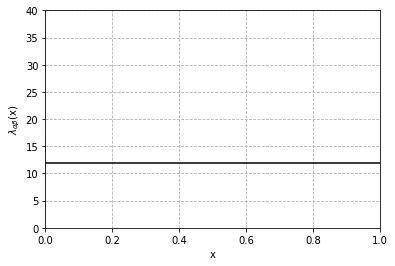

In [ ]:
plt.plot(x, lambda_ab_value, color = 'k')
plt.xlabel('x')
plt.ylabel('$\lambda_{\\alpha\\beta}$(x)')
plt.xlim([0, 1])
plt.ylim([0, 40])
plt.grid(linestyle='--')

# plt.savefig(
#     'lambda_func.eps'.format(index),
#     format='eps',
#     bbox_inches='tight')
# files.download('lambda_func.eps'.format(index)) 

In [ ]:
def p(x, epsilon, alpha, beta):
    return (epsilon*alpha**2*np.tanh(beta)*np.exp((1-x)*alpha*np.tanh(beta)))*(np.tanh(beta)-np.tanh(beta-alpha*x))

### PDE System

In [ ]:
def lambda_ab(x, epsilon, alpha, beta):
#     print(np.cosh(alpha*x-beta))
    # return (2*epsilon*alpha**2)/((np.cosh(alpha*x-beta))**2)
    return 12

In [ ]:
# Boundary conditions (fixed temperature)
u_left = 0.0
mu, sigma = 30, 10
nx = 100
max_iter_time = 5000
u0 = np.random.normal(mu, sigma, (max_iter_time+1, nx+1))

# plate size, mm
L = 1.

# intervals in x-, y- directions, mm
dx = L/nx #0.01

# Thermal diffusivity of steel, mm2.s-1
epsilon = 1
alpha = 4
beta = 2

dx2 = dx * dx

dt =  dx2/(4*epsilon)
gamma = (epsilon * dt) / dx2


# ## Set initial condition
for i in range(nx+1):
  u0[0, i] = 24.25*np.sin(np.pi*i*dx)

## Set the boundary conditions
u0[:, 0] = 0
u0[:, nx] = 0

u = u0.copy()

#Groundtruth system: FDM solver
for t in range(0, max_iter_time, 1):
  for i in range(1, nx):
      x = i*dx
      lambda_x = lambda_ab(x, epsilon, alpha, beta)
      if(i < nx):
        u[t + 1, i] = u[t, i] + gamma * (u[t, i+1] + u[t, i-1] - 2*u[t, i]) + lambda_x*dt*u[t, i]
      else:
        u[t + 1, i] = u[t, i] + gamma * (u[t, i-1] + u[t, i-1] - 2*u[t, i]) + lambda_x*dt*u[t, i]


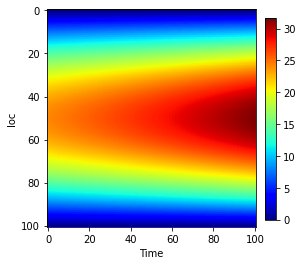

In [ ]:
vmax = np.max(u)
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4,4))
plt.subplot(1, 1, 1)
im1 = plt.imshow(u[::50, :].T, vmin=0, vmax=vmax, cmap='jet', aspect='auto')
plt.xlabel('Time')
plt.ylabel('loc')
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(im1, cax=cbar_ax)

ax.azim = -30
ax.dist = 10
ax.elev = 30


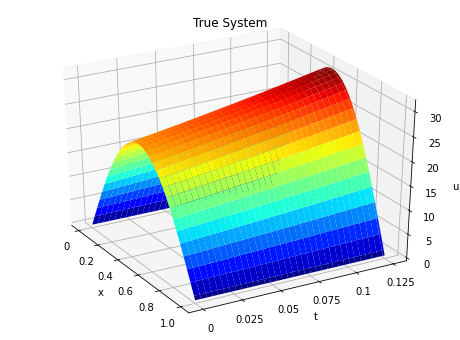

In [ ]:
index = 84

fig = plt.figure(figsize=(8, 6))
ax = fig.gca(projection='3d')

azim = -30
dist = 10
elev = 30

# Make data.
X = np.arange(0, 5001, 50)
Y = np.arange(0, 101, 1)
X, Y = np.meshgrid(X, Y)
vmax = np.max(u[::50, :])

# Plot the surface.
surf = ax.plot_surface(Y, X, u[::50, :].T, cmap='jet', vmin=0, vmax=vmax)

# Labels.
ax.set_xlabel('x')
ax.set_xticks([0, 20, 40, 60, 80, 100]) # values
ax.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0]) # labels
ax.set_ylabel('t')
ax.set_yticks([0, 1000, 2000, 3000, 4000, 5000]) # values
ax.set_yticklabels([0, 1000*dt, 2000*dt, 3000*dt, 4000*dt, 5000*dt]) # labels
ax.set_zlabel('u')
ax.set_title('True System')
# ax.set_zlim([0, 120])

if azim is not None:
    ax.azim = azim
if dist is not None:
    ax.dist = dist
if elev is not None:
    ax.elev = elev

print('ax.azim = {}'.format(ax.azim))
print('ax.dist = {}'.format(ax.dist))
print('ax.elev = {}'.format(ax.elev))

# plt.savefig(
#     'truey_text{}.eps'.format(index),
#     format='eps',
#     bbox_inches='tight')
# files.download('truey_text{}.eps'.format(index)) 

### Prescribed-time observer

In [ ]:
from mpmath import *
mp.dps = 15; mp.pretty = True

In [ ]:
from math import factorial

def product(iterable):
    prod = 1
    for n in iterable:
        prod *= n
    return prod
    
def npr(n, r):
    """
    Calculate the number of ordered permutations of r items taken from a
    population of size n.

    >>> npr(3, 2)
    6
    >>> npr(100, 20)
    1303995018204712451095685346159820800000
    """
    assert 0 <= r <= n
    return product(range(n - r + 1, n + 1))

def ncr(n, r):
    """
    Calculate the number of unordered combinations of r items taken from a
    population of size n.

    >>> ncr(3, 2)
    3
    >>> ncr(100, 20)
    535983370403809682970
    >>> ncr(100000, 1000) == ncr(100000, 99000)
    True
    """
    assert 0 <= r <= n
    if r > n // 2:
        r = n - r
    return npr(n, r) // factorial(r)

In [ ]:
x = 0.01
T = 0.25
t = 0.01
mu = 1

In [ ]:
#It may be late answer but the following works well.
repetitions = 10

sum_n = 0.0

for n in range(repetitions):
  multiplier_n = np.power((1-x**2)/4/(T-t), n) * np.power(-1, n)/np.math.factorial(n+1) 
  
  sum_j = 0.0
  for j in range(n):
    multiplier_j = (1/np.math.factorial(j))*np.power((-mu*T**3)/2/(T-t)**2, j)
    sum_k = 0.0
    for k in range(j):
      cur_k = ncr(j, k) * ncr(n+2+k, n-j)
      sum_k +=  cur_k
    cur_j = multiplier_j*sum_k
    sum_j += cur_j
  
  cur_n = multiplier_n*sum_j
  sum_n += cur_n

p_xt = mu*T**3*x/2/(T-t)**3*sum_n

print('repetitions', repetitions, 'sum', sum_n)

repetitions 10 sum 0.0


In [ ]:
# #It may be late answer but the following works well.
# repetitions = 10

# sum_n = 0.0
# for n in range(repetitions):
#   cur_n = np.power((1-x**2)/4/(T-t), n) * np.power(-1, n)/np.math.factorial(n+1)
#   sum_n += cur_n
  
# sum_j = 0.0
# for j in range(n):
#   cur_j = (1/np.math.factorial(j))*np.power((-mu*T**3)/2/(T-t)**2, j)
#   sum_j += cur_j

# sum_k = 0.0
# for k in range(j):
#   cur_k = ncr(j, k) * ncr(n+2+k, n-j)
#   sum_k +=  cur_k

# p_xt = mu*T**3*x/2/(T-t)**3*sum_n*sum_j*sum_k

# print('repetitions', repetitions, 'sum', p_xt)

In [ ]:
def p(x, t, T, mu0 = 1, repetitions = 10):
  #numerical approximation of the infinite sum
  # repetitions = 50

  sum_n = 0.0

  #setting a lower bound for T-t
  delta_t = np.max([T-t, 0.3*T])


  for n in range(repetitions):
    multiplier_n = np.power((1-x**2)/4/delta_t, n) * np.power(-1, n)/np.math.factorial(n+1) 
    
    sum_j = 0.0
    for j in range(n):
      multiplier_j = (1/np.math.factorial(j))*np.power((-mu*T**3)/2/delta_t**2, j)
      sum_k = 0.0
      for k in range(j):
        cur_k = ncr(j, k) * ncr(n+2+k, n-j)
        sum_k +=  cur_k
      cur_j = multiplier_j*sum_k
      sum_j += cur_j
    
    cur_n = multiplier_n*sum_j
    sum_n += cur_n

  p_xt = mu0*T**3*x/2/delta_t**3*sum_n
  return p_xt

In [ ]:
# Boundary conditions (fixed temperature)
u_left = 0.0
mu, sigma = 30, 10
nx = 100
max_iter_time = 4000

u0_est = np.zeros((max_iter_time+1, nx+1))

## Set the initial conditions
u0_est[0, :] = 0

## Set the boundary conditions
u0_est[:, 0] = 0

u_hat = u0_est.copy()

# plate size, mm
L = 1.

# intervals in x-, y- directions, mm
dx = L/nx #0.01

# Thermal diffusivity of steel, mm2.s-1
epsilon = 1
alpha = 4
beta = 2

dx2 = dx * dx

dt = dx2/(4*epsilon)
gamma = (epsilon * dt) / dx2

#Observer: Prescribed-time Observer
u_hat = u0_est.copy()
T = max_iter_time * dt

for t in range(0, max_iter_time, 1):
  tt = t*dt
  
  for i in range(1, nx+1): #if x is not the boundary
      x = i*dx
      lambda_x = 12
      
      p_xt = p(x, tt, T)
      if(t%100 == 0 and i == 2):
        print('Current time', tt, 'prescribed time', T, 'p(x, t)', p_xt)
      
      u_x1t = (u[t, nx] - u[t, nx-1])/dx
      u_hat_x1t = (u_hat[t, nx] - u_hat[t, nx-1])/dx

      if(i < nx):
        u_hat[t + 1, i] = (u_hat[t, i] + gamma * (u_hat[t, i+1] + u_hat[t, i-1] - 2*u_hat[t, i]) 
        + lambda_x*dt*u_hat[t, i] + p_xt*dt*(u_x1t-u_hat_x1t))
      else:
        u_hat[t + 1, i] = (u_hat[t, i] + gamma * (u_hat[t, i-1] + u_hat[t, i-1] - 2*u_hat[t, i]) 
        + lambda_x*dt*u_hat[t, i] + p_xt*dt*(u_x1t-u_hat_x1t))

Current time 0.0 prescribed time 0.1 p(x, t) -0.09133622699564356
Current time 0.0025 prescribed time 0.1 p(x, t) -0.11887641398062854
Current time 0.005 prescribed time 0.1 p(x, t) -0.15686332950339876
Current time 0.007500000000000001 prescribed time 0.1 p(x, t) -0.2101466405094444
Current time 0.01 prescribed time 0.1 p(x, t) -0.2862743485968703
Current time 0.0125 prescribed time 0.1 p(x, t) -0.3972614575668832
Current time 0.015000000000000001 prescribed time 0.1 p(x, t) -0.5627041741349893
Current time 0.0175 prescribed time 0.1 p(x, t) -0.8154133555569696
Current time 0.02 prescribed time 0.1 p(x, t) -1.2119050922851706
Current time 0.022500000000000003 prescribed time 0.1 p(x, t) -1.852558349571499
Current time 0.025 prescribed time 0.1 p(x, t) -2.9216939492221345
Current time 0.0275 prescribed time 0.1 p(x, t) -4.7703166051207795
Current time 0.030000000000000002 prescribed time 0.1 p(x, t) -8.094232589076531
Current time 0.0325 prescribed time 0.1 p(x, t) -14.335926093004982


In [ ]:
from numpy import linalg as LA

In [ ]:
unorm = LA.norm(u[0:4000], axis=1)
uhatnorm = LA.norm(u_hat[0:4000], axis=1)

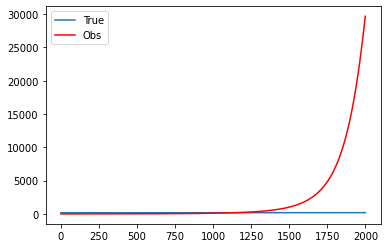

In [ ]:
plt.plot(unorm[0:2000], label = 'True')
# plt.plot(u[0, :], label = 'True')

plt.plot(uhatnorm[0:2000], 'r', label = 'Obs')
# plt.plot(u_hat[0, :], 'r-.', label = 'Obs')

plt.legend()

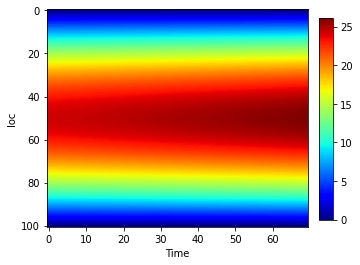

In [ ]:
vmax = np.max(u[0:1400])
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
plt.subplot(1, 1, 1)
im1 = plt.imshow(u[0:1400:20, :].T, vmin=0, vmax=vmax, cmap='jet', aspect='auto')
plt.xlabel('Time')
plt.ylabel('loc')
# plt.colorbar()
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(im1, cax=cbar_ax)

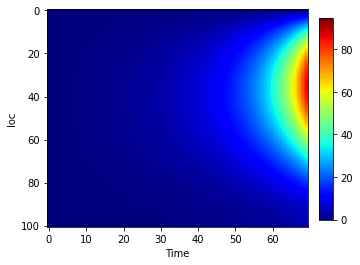

In [ ]:
vmax = np.max(u_hat[0:1400])
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
# plt.subplot(1, 2, 1)
# im1 = plt.imshow(u[0:4000:50, :].T, vmin=0, vmax=vmax, cmap='jet', aspect='auto')
# plt.xlabel('Time')
# plt.ylabel('loc')
plt.subplot(1, 1, 1)
im2 = plt.imshow(u_hat[0:1400:20, :].T, vmin=0, vmax=vmax, cmap='jet', aspect='auto')
plt.xlabel('Time')
plt.ylabel('loc')
# plt.colorbar()
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(im2, cax=cbar_ax)

ax.azim = -30
ax.dist = 10
ax.elev = 30


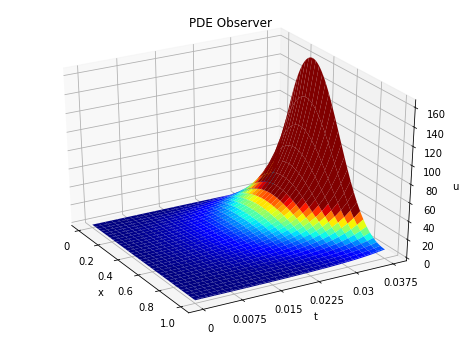

In [ ]:
index = 84

fig = plt.figure(figsize=(8, 6))
ax = fig.gca(projection='3d')

azim = -30
dist = 10
elev = 30

# Make data.
X = np.arange(0, 1501, 50)
Y = np.arange(0, 101, 1)
X, Y = np.meshgrid(X, Y)
vmax = np.max(u[::50, :])

# Plot the surface.
surf = ax.plot_surface(Y, X, u_hat[0:1501:50, :].T, cmap='jet', vmin=0, vmax=vmax)

# Labels.
ax.set_xlabel('x')
ax.set_xticks([0, 20, 40, 60, 80, 100]) # values
ax.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0]) # labels
ax.set_ylabel('t')
ax.set_yticks([0, 300, 600, 900, 1200, 1500]) # values
ax.set_yticklabels([0, np.round(300*dt, 4), np.round(600*dt, 4), np.round(900*dt, 4), 
                    np.round(1200*dt, 4), np.round(1500*dt, 4)]) # labels
ax.set_zlabel('u')
ax.set_title('PDE Observer')
# ax.set_zlim([0, 120])

if azim is not None:
    ax.azim = azim
if dist is not None:
    ax.dist = dist
if elev is not None:
    ax.elev = elev

print('ax.azim = {}'.format(ax.azim))
print('ax.dist = {}'.format(ax.dist))
print('ax.elev = {}'.format(ax.elev))

# plt.savefig(
#     'truey_text{}.eps'.format(index),
#     format='eps',
#     bbox_inches='tight')
# files.download('truey_text{}.eps'.format(index)) 

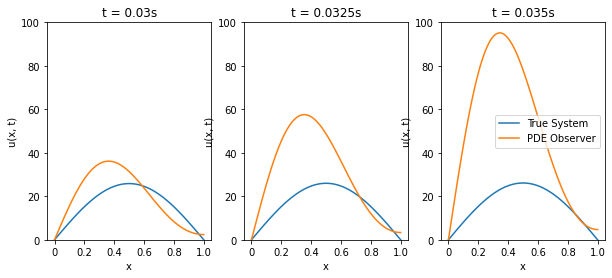

In [ ]:
index_t = 1200

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10,4))
plt.subplot(1, 3, 1)
plt.plot(u[index_t, :], label = 'True System')
plt.plot(u_hat[index_t, :], label = 'PDE Observer')
plt.ylim([0, 100])
plt.xlabel('x')
plt.xticks([0, 20, 40, 60, 80, 100], [0, 0.2, 0.4, 0.6, 0.8, 1.0]) # values
plt.ylabel('u(x, t)')
plt.title('t = 0.03s')

plt.subplot(1, 3, 2)
plt.plot(u[index_t+100, :], label = 'True System')
plt.plot(u_hat[index_t+100, :], label = 'PDE Observer')
plt.ylim([0, 100])
plt.xlabel('x')
plt.xticks([0, 20, 40, 60, 80, 100], [0, 0.2, 0.4, 0.6, 0.8, 1.0]) # values
plt.ylabel('u(x, t)')
plt.title('t = 0.0325s')

plt.subplot(1, 3, 3)
plt.plot(u[index_t+200, :], label = 'True System')
plt.plot(u_hat[index_t+200, :], label = 'PDE Observer')
plt.ylim([0, 100])
plt.xlabel('x')
plt.xticks([0, 20, 40, 60, 80, 100], [0, 0.2, 0.4, 0.6, 0.8, 1.0]) # values
plt.ylabel('u(x, t)')
plt.title('t = 0.035s')

plt.legend()

In [ ]:
L = 1.

# intervals in x-, y- directions, mm
dx = 0.01

# Thermal diffusivity of steel, mm2.s-1
epsilon = 1
alpha = 4
beta = 2

Tcool, Thot = 0.0, 100.0

dx2 = dx * dx

dt = dx2/(4*epsilon)
gamma = (epsilon * dt) / dx2
dt*5000

0.125

In [ ]:
num = 100
n_train = 1024
n_test = 200
nx = 100
max_iter_time = 5000

In [ ]:
obs_data = torch.zeros((num, max_iter_time+1, nx+1))
sys_data = torch.zeros((num, max_iter_time+1, nx+1))
boundary_data = torch.zeros((num, max_iter_time+1, 1))

# Boundary conditions (fixed temperature)
u_left = 0.0
mu, sigma = 30, 10

for i in range(num):
  if(i%10 == 0):
    print('Generating ', i, 'Data Points!')
  
  # initialize the true system
  #Thot = np.random.uniform(0, 100)
  #u0 = Thot*np.ones((max_iter_time+1, nx+1))
  u0 = np.random.normal(mu, sigma, (max_iter_time+1, nx+1)) #np.random.gaussian((max_iter_time+1, nx+1))
  
  ## Set the boundary conditions
  u0[:, 0] = u_left

  # initialize the estimator
  Thot_est = 0.0 #np.random.uniform(0, 100)
  u0_est = Thot_est*np.ones((max_iter_time+1, nx+1))
  ## Set the boundary conditions
  u0_est[:, 0] = u_left

  a = datetime.datetime.now()
  obs, sys, u1 = data_generation_observer(u0, u0_est, nx = int(nx), max_iter_time = max_iter_time)
  b = datetime.datetime.now()
  print(b-a)

  obs_data[i, :, :] =  torch.from_numpy(obs)
  sys_data[i, :, :] =  torch.from_numpy(sys)
  boundary_data[i, :, :] =  torch.from_numpy(u1.reshape((-1, 1)))
  # x_data[i, 0:nx+1] = torch.from_numpy(u0_est[0, :])
  # x_data[i, nx+1:nx+1+max_iter_time+1] = torch.from_numpy(u1)
  
  # y_data[i, :] = torch.from_numpy(obs_T)
  # sys_data[i, :] = torch.from_numpy(sys_T)


Generating  0 Data Points!
0:00:07.897182
0:00:07.735368
0:00:07.701144
0:00:07.797732
0:00:07.847966
0:00:07.976555
0:00:07.840403
0:00:07.714655
0:00:07.766060
0:00:07.797055
Generating  10 Data Points!
0:00:07.949978
0:00:07.875787
0:00:07.864708
0:00:07.673386
0:00:07.701936
0:00:07.876524
0:00:07.755995
0:00:08.130744
0:00:07.896958
0:00:07.772628
Generating  20 Data Points!
0:00:07.878729
0:00:07.904331
0:00:07.914258
0:00:07.637496
0:00:07.903929
0:00:07.808495
0:00:07.903783
0:00:07.709837
0:00:08.057940
0:00:07.898064
Generating  30 Data Points!
0:00:07.899591
0:00:07.853256
0:00:07.686436
0:00:07.691588
0:00:07.755972
0:00:07.810630
0:00:08.077779
0:00:07.852697
0:00:07.825672
0:00:07.779367
Generating  40 Data Points!
0:00:07.799117
0:00:07.893499
0:00:07.711030
0:00:07.836744
0:00:07.630384
0:00:07.877145
0:00:07.884922
0:00:07.782429
0:00:08.006758
0:00:07.873477
Generating  50 Data Points!
0:00:07.895019
0:00:07.771173
0:00:07.784697
0:00:07.723232
0:00:07.651887
0:00:07.

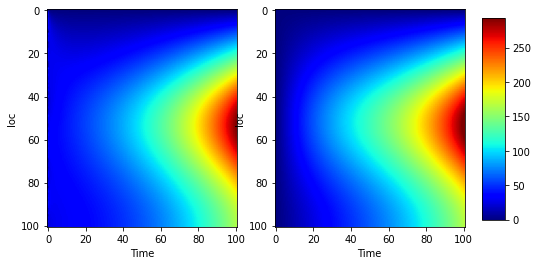

In [ ]:
vmax = np.max(sys)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
plt.subplot(1, 2, 1)
im1 = plt.imshow(sys[::50, :].T, vmin=0, vmax=vmax, cmap='jet', aspect='auto')
plt.xlabel('Time')
plt.ylabel('loc')
plt.subplot(1, 2, 2)
im2 = plt.imshow(obs[::50, :].T, vmin=0, vmax=vmax, cmap='jet', aspect='auto')
plt.xlabel('Time')
plt.ylabel('loc')
# plt.colorbar()
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(im2, cax=cbar_ax)

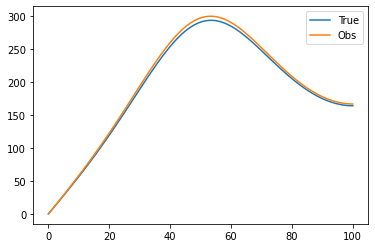

In [ ]:
plt.plot(sys[-1, :], label = 'True')

plt.plot(obs[-1, :], label = 'Obs')

plt.legend()

### Model Training

In [ ]:
# reading data
class MatReader(object):
    def __init__(self, file_path, to_torch=True, to_cuda=False, to_float=True):
        super(MatReader, self).__init__()

        self.to_torch = to_torch
        self.to_cuda = to_cuda
        self.to_float = to_float

        self.file_path = file_path

        self.data = None
        self.old_mat = None
        self._load_file()

    def _load_file(self):
        try:
            self.data = scipy.io.loadmat(self.file_path)
            self.old_mat = True
        except:
            self.data = h5py.File(self.file_path)
            self.old_mat = False

    def load_file(self, file_path):
        self.file_path = file_path
        self._load_file()

    def read_field(self, field):
        x = self.data[field]

        if not self.old_mat:
            x = x[()]
            x = np.transpose(x, axes=range(len(x.shape) - 1, -1, -1))

        if self.to_float:
            x = x.astype(np.float32)

        if self.to_torch:
            x = torch.from_numpy(x)

            if self.to_cuda:
                x = x.cuda()

        return x

    def set_cuda(self, to_cuda):
        self.to_cuda = to_cuda

    def set_torch(self, to_torch):
        self.to_torch = to_torch

    def set_float(self, to_float):
        self.to_float = to_float

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
################################################################
# configs
################################################################
# sys_data_PATH = '/content/drive/My Drive/Colab Notebooks/data/PTPDEsys.mat'
# obs_data_PATH = '/content/drive/My Drive/Colab Notebooks/data/PTPDEobs.mat'
# boundary_data_PATH = '/content/drive/My Drive/Colab Notebooks/data/PTPDEboundary.mat'
sys_data_PATH = '/content/drive/My Drive/Colab Notebooks/data/sys_data.mat'
obs_data_PATH = '/content/drive/My Drive/Colab Notebooks/data/obs_data.mat'

In [ ]:
sys_reader = MatReader(sys_data_PATH)
sys_data = sys_reader.read_field('sys_data')

obs_reader = MatReader(obs_data_PATH)
obs_data = obs_reader.read_field('obs_data')

# boundary_reader = MatReader(boundary_data_PATH)
# boundary_data = boundary_reader.read_field('boundary_data')

In [ ]:
nt = obs_data.shape[1]
nx = obs_data.shape[2]

In [ ]:
initial = obs_data[:, 0:1, :]
init_cond = initial.repeat(1, nt, 1)
# initial_pturb = initial+ 0.05* torch.rand(initial.shape) 

boundary = sys_data[:, :, -1:].repeat(1, 1, nx) #right boundary

x_data = torch.stack([init_cond, boundary], dim=-1)
x_data = torch.permute(x_data, (0, 2, 1, 3))
y_data = torch.unsqueeze(obs_data, -1)
y_data = torch.permute(y_data, (0, 2, 1, 3))
truey_data = torch.unsqueeze(sys_data, -1)
truey_data = torch.permute(truey_data, (0, 2, 1, 3))

print(x_data.shape, y_data.shape)

torch.Size([1200, 48, 100, 2]) torch.Size([1200, 48, 100, 1])


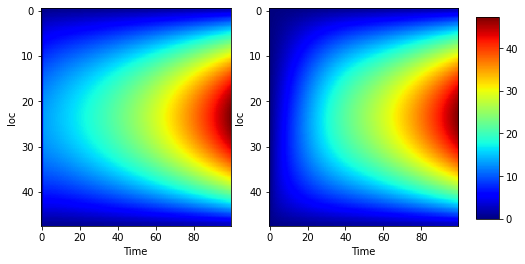

In [ ]:
index = 2
vmax = np.max(truey_data[index, :, :, 0].numpy())
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,4))
plt.subplot(1, 2, 1)
im1 = plt.imshow(truey_data[index, :, :, 0], vmin=0, vmax=vmax, cmap='jet', aspect='auto')
plt.xlabel('Time')
plt.ylabel('loc')
plt.subplot(1, 2, 2)
im2 = plt.imshow(y_data[index, :, :, 0], vmin=0, vmax=vmax, cmap='jet', aspect='auto')
plt.xlabel('Time')
plt.ylabel('loc')
# plt.colorbar()
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(im2, cax=cbar_ax)

### Train FNO for Observer

In [ ]:
################################################################
#  configurations
################################################################
ntrain = 1000
ntest = 100

sub = 2**3 #subsampling rate
h = 2**13 // sub #total grid size divided by the subsampling rate
s = nx #h
T = nt

batch_size = 20
learning_rate = 0.001

epochs = 500
step_size = 100
gamma = 0.5

modes = 12
width = 32

In [ ]:
T = nt = 100

x_train = x_data[:ntrain, :, 0:nt, :]
y_train = y_data[:ntrain, :, 0:nt, :]
x_test = x_data[-ntest:, :, 0:nt, :]
y_test = y_data[-ntest:, :, 0:nt, :]
truey_test = truey_data[-ntest:, :, 0:nt, :]
truey_train = truey_data[:ntrain, :, 0:nt, :]

x_train = x_train.reshape(ntrain, s, T, 2)
x_test = x_test.reshape(ntest, s, T, 2)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

In [ ]:
# model
model = FNO2d(modes, modes, width).cuda().cuda()
print(count_params(model))

2368033


In [ ]:
################################################################
# training and evaluation
################################################################
optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

myloss = LpLoss(size_average=False)
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_mse = 0
    train_l2 = 0
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()
        out = model(x)

        mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1), reduction='mean')
        l2 = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2.backward() # use the l2 relative loss

        optimizer.step()
        train_mse += mse.item()
        train_l2 += l2.item()

    scheduler.step()
    model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.cuda(), y.cuda()

            out = model(x)
            test_l2 += myloss(out.view(batch_size, -1), y.view(batch_size, -1)).item()

    train_mse /= len(train_loader)
    train_l2 /= ntrain
    test_l2 /= ntest

    t2 = default_timer()
    print(ep, t2-t1, train_mse, train_l2, test_l2)

0 2.152274088000013 204.81271968841554 0.6603592071533203 0.18586039066314697
1 1.8085069279995878 4.133062040284276 0.07721639677882194 0.014759598672389984
2 1.7985996010002054 0.08063661627471447 0.013874079376459122 0.013867948949337006
3 1.7972535980002249 0.0852101492881775 0.014390875399112702 0.021140485405921935
4 1.7991987609998432 0.06084783861413598 0.01188015729188919 0.0103476282954216
5 1.8145141059999332 0.05070689326152206 0.010731154046952724 0.008580773621797561
6 1.819659459000377 0.028883879408240318 0.007963894955813886 0.01583101987838745
7 1.796074014000169 0.02527863807976246 0.0072615350633859635 0.006691284403204918
8 1.7986113980000482 0.020383379743434488 0.006568462647497654 0.006389626488089562
9 1.804652317000091 0.02499327109195292 0.007467227589339018 0.009515302181243896
10 1.7990940489999048 0.03883876061066985 0.009723722383379936 0.009490836709737778
11 1.7995815429999311 0.027731763841584326 0.007721919693052769 0.01128882572054863
12 1.8112537219

In [ ]:
torch.save(model.state_dict(), '/content/drive/My Drive/Colab Notebooks/data/fno2d_PTobserver0314')

In [ ]:
model = FNO2d(modes, modes, width).cuda().cuda()
model.load_state_dict(torch.load('/content/drive/My Drive/Colab Notebooks/data/heat_fno2d_PTobserver'))

<All keys matched successfully>

In [ ]:
x_test.shape

torch.Size([100, 48, 100, 2])

In [ ]:
pred = torch.zeros(y_test.shape)
index = 0
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=1, shuffle=False)
test_l2 = 0.0
myloss = LpLoss(size_average=False)

a = datetime.datetime.now()
with torch.no_grad():
    for x, y in test_loader:
        
        x, y = x.cuda(), y.cuda()

        out = model(x) #.view(-1)
        pred[index] = out

        test_l2 += myloss(out.view(1, -1), y.view(1, -1)).item()
        index = index + 1

b = datetime.datetime.now()
print((b-a)/len(test_loader))

test_l2 /= len(test_loader)
print('Test L2', test_l2)

0:00:00.005845
Test L2 0.0002586295771470759


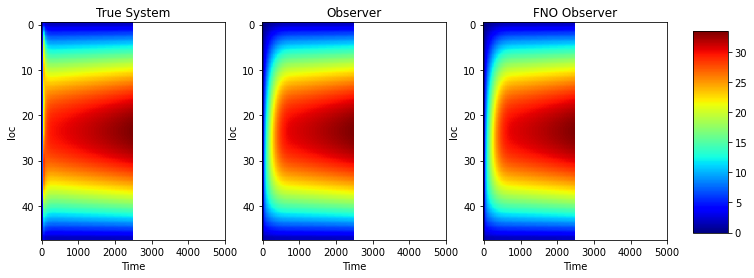

In [ ]:
index = 46
vmax = truey_test[index, :, :, 0].max()
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
plt.subplot(1, 3, 1)
im1 = plt.imshow(truey_test[index, :, :, 0], vmin=0, vmax=vmax, cmap='jet', aspect='auto')
plt.xlabel('Time')
plt.xticks([0, 20, 40, 60, 80, 100], [0, 1000, 2000, 3000, 4000, 5000])
plt.ylabel('loc')
plt.title('True System')
plt.subplot(1, 3, 2)
im2 = plt.imshow(y_test[index, :, :, 0], vmin=0, vmax=vmax, cmap='jet', aspect='auto')
plt.xlabel('Time')
plt.xticks([0, 20, 40, 60, 80, 100], [0, 1000, 2000, 3000, 4000, 5000])
plt.ylabel('loc')
plt.title('Observer')
plt.subplot(1, 3, 3)
im3 = plt.imshow(pred[index, :, :, 0], vmin=0, vmax=vmax, cmap='jet', aspect='auto')
plt.xlabel('Time')
plt.xticks([0, 20, 40, 60, 80, 100], [0, 1000, 2000, 3000, 4000, 5000])
plt.ylabel('loc')
plt.title('FNO Observer')
# plt.colorbar()
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(im3, cax=cbar_ax)

In [ ]:
truey_test.shape

torch.Size([100, 48, 100, 1])

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
import numpy as np

In [ ]:
SMALL_SIZE = 14
MEDIUM_SIZE = 14
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


ax.azim = -60
ax.dist = 10
ax.elev = 30


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

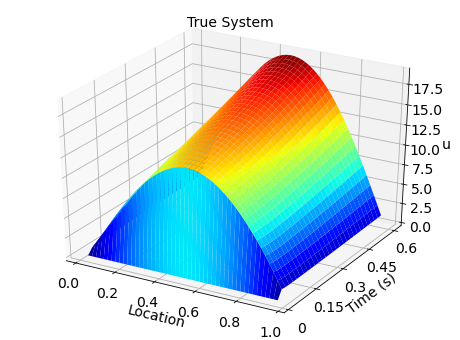

In [ ]:
index = 4

fig = plt.figure(figsize=(8, 6))
ax = fig.gca(projection='3d')

azim = -60
dist = 10
elev = 30

# Make data.
X = np.arange(0.02, 0.98, 0.02)
Y = np.arange(0.02, 0.62, 0.02)
X, Y = np.meshgrid(X, Y)
vmax = np.max(truey_test[index, :, 0:30, 0].detach().numpy())

# Plot the surface.
# surf = ax.plot_surface(X, Y, y_test[index, :, :, 0].detach().numpy(), cmap='jet', vmin=0, vmax=vmax)
surf = ax.plot_surface(X, Y, truey_test[index, :, 0:30, 0].detach().numpy().T, cmap='jet', vmin=0, vmax=vmax)

# Labels.
ax.set_xlabel('Location')
ax.set_ylabel('Time (s)')
ax.set_yticks([0, 0.15, 0.3, 0.45, 0.6]) # values
ax.set_yticklabels([0, 0.15, 0.3, 0.45, 0.6]) # labels
ax.set_zlabel('u')
ax.set_title('True System')
# ax.set_zlim([0, 120])

if azim is not None:
    ax.azim = azim
if dist is not None:
    ax.dist = dist
if elev is not None:
    ax.elev = elev

print('ax.azim = {}'.format(ax.azim))
print('ax.dist = {}'.format(ax.dist))
print('ax.elev = {}'.format(ax.elev))

plt.savefig(
    'PTobs_text{}.eps'.format(index),
    format='eps',
    bbox_inches='tight')
# files.download('PTobs_text{}.eps'.format(index)) 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


ax.azim = -60
ax.dist = 10
ax.elev = 30


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

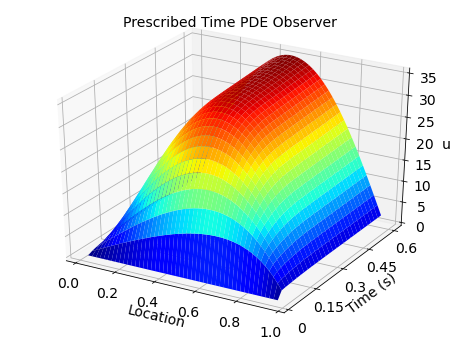

In [ ]:
index = 14

fig = plt.figure(figsize=(8, 6))
ax = fig.gca(projection='3d')

azim = -60
dist = 10
elev = 30

# Make data.
X = np.arange(0.02, 0.98, 0.02)
Y = np.arange(0.02, 0.62, 0.02)
X, Y = np.meshgrid(X, Y)
vmax = np.max(truey_test[index, :, 0:30, 0].detach().numpy())

# Plot the surface.
# surf = ax.plot_surface(X, Y, y_test[index, :, :, 0].detach().numpy(), cmap='jet', vmin=0, vmax=vmax)
surf = ax.plot_surface(X, Y, y_test[index, :, 0:30, 0].detach().numpy().T, cmap='jet', vmin=0, vmax=vmax)

# Labels.
ax.set_xlabel('Location')
ax.set_ylabel('Time (s)')
ax.set_yticks([0, 0.15, 0.3, 0.45, 0.6]) # values
ax.set_yticklabels([0, 0.15, 0.3, 0.45, 0.6]) # labels
ax.set_zlabel('u')
ax.set_title('Prescribed Time PDE Observer')
# ax.set_zlim([0, 120])

if azim is not None:
    ax.azim = azim
if dist is not None:
    ax.dist = dist
if elev is not None:
    ax.elev = elev

print('ax.azim = {}'.format(ax.azim))
print('ax.dist = {}'.format(ax.dist))
print('ax.elev = {}'.format(ax.elev))

plt.savefig(
    'PTobs_text{}.eps'.format(index),
    format='eps',
    bbox_inches='tight')
files.download('PTobs_text{}.eps'.format(index)) 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


ax.azim = -60
ax.dist = 10
ax.elev = 30


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

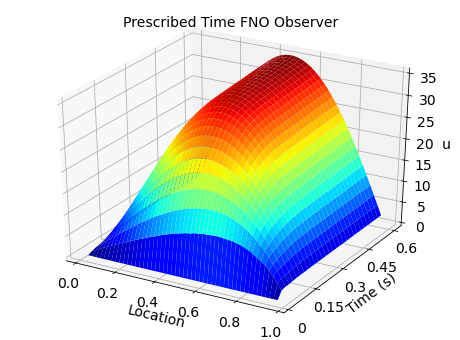

In [ ]:
index = 14

fig = plt.figure(figsize=(8, 6))
ax = fig.gca(projection='3d')

azim = -60
dist = 10
elev = 30

# Make data.
X = np.arange(0.02, 0.98, 0.02)
Y = np.arange(0.02, 0.62, 0.02)
X, Y = np.meshgrid(X, Y)
vmax = np.max(truey_test[index, :, 0:30, 0].detach().numpy())

# Plot the surface.
# surf = ax.plot_surface(X, Y, y_test[index, :, :, 0].detach().numpy(), cmap='jet', vmin=0, vmax=vmax)
surf = ax.plot_surface(X, Y, pred[index, :, 0:30, 0].detach().numpy().T, cmap='jet', vmin=0, vmax=vmax)

# Labels.
ax.set_xlabel('Location')
ax.set_ylabel('Time (s)')
ax.set_yticks([0, 0.15, 0.3, 0.45, 0.6]) # values
ax.set_yticklabels([0, 0.15, 0.3, 0.45, 0.6]) # labels
ax.set_zlabel('u')
ax.set_title('Prescribed Time FNO Observer')
# ax.set_zlim([0, 120])

if azim is not None:
    ax.azim = azim
if dist is not None:
    ax.dist = dist
if elev is not None:
    ax.elev = elev

print('ax.azim = {}'.format(ax.azim))
print('ax.dist = {}'.format(ax.dist))
print('ax.elev = {}'.format(ax.elev))

plt.savefig(
    'PTFNO_text{}.eps'.format(index),
    format='eps',
    bbox_inches='tight')
files.download('PTFNO_text{}.eps'.format(index)) 

In [ ]:
truey_test[index, :, :, 0].shape

torch.Size([48, 100])

In [ ]:
X

<Figure size 432x288 with 0 Axes>

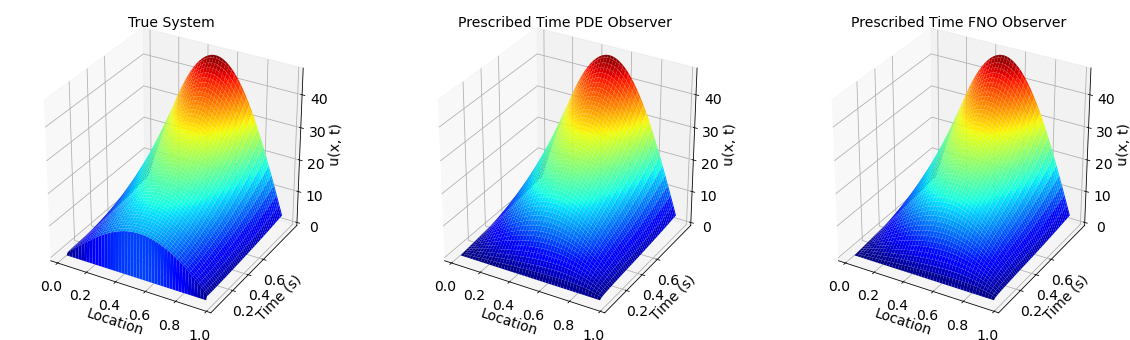

In [ ]:
index = 4

f = plt.figure()
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 6), subplot_kw={"projection": "3d"})
# Make data.
X = np.arange(0.02, 0.98, 0.02)
Y = np.arange(0.00, 1.00, 0.01)
X, Y = np.meshgrid(X, Y)
vmax = np.max(truey_test[index, :, :, 0].detach().numpy())

# Plot the surface.
surf1 = ax[0].plot_surface(X, Y, truey_test[index, :, :, 0].detach().numpy().T, cmap='jet', vmin=0, vmax=vmax)
ax[0].set_xlabel('Location')
ax[0].set_ylabel('Time (s)')
ax[0].set_zlabel('u(x, t)')
ax[0].set_yticks([0.2, 0.4, 0.6]) # values
ax[0].set_yticklabels([0.2, 0.4, 0.6]) # labels
# ax[0].set_zlim([0, 120])
ax[0].set_title('True System')
surf2 = ax[1].plot_surface(X, Y, y_test[index, :, :, 0].detach().numpy().T, cmap='jet', vmin=0, vmax=vmax)
ax[1].set_xlabel('Location')
ax[1].set_ylabel('Time (s)')
ax[1].set_yticks([0.2, 0.4, 0.6]) # values
ax[1].set_yticklabels([0.2, 0.4, 0.6]) # labels
ax[1].set_zlabel('u(x, t)')
# ax[1].set_zlim([0, 120])
ax[1].set_title('Prescribed Time PDE Observer')
surf3 = ax[2].plot_surface(X, Y, pred[index, :, :, 0].detach().numpy().T, cmap='jet', vmin=0, vmax=vmax)
ax[2].set_xlabel('Location')
ax[2].set_ylabel('Time (s)')
ax[2].set_yticks([0.2, 0.4, 0.6]) # values
ax[2].set_yticklabels([0.2, 0.4, 0.6]) # labels
ax[2].set_zlabel('u(x, t)')
ax[2].set_title('Prescribed Time FNO Observer')
# ax[2].set_zlim([0, 120])

# fig.subplots_adjust(right=0.85)
# cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
# fig.colorbar(surf1, shrink=0.5, cax=cbar_ax)
# fig.colorbar(surf1, shrink=0.5, aspect=5)

plt.show()
f.savefig('PT_observer.eps', format='eps')

In [ ]:
from google.colab import files
files.download('PT_observer.eps') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
index = 4 #20

In [ ]:
error1 = truey_test[index, :, :, 0] - y_test[index, :, :, 0]
error2 = truey_test[index, :, :, 0] - pred[index, :, :, 0]

error1norm= np.zeros((nt, 1));
error2norm= np.zeros((nt, 1));
for k in range(nt):
  error1norm[k] = np.sqrt(error1[:,k].T@error1[:,k]);
  error2norm[k] = np.sqrt(error2[:,k].T@error2[:,k]);

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

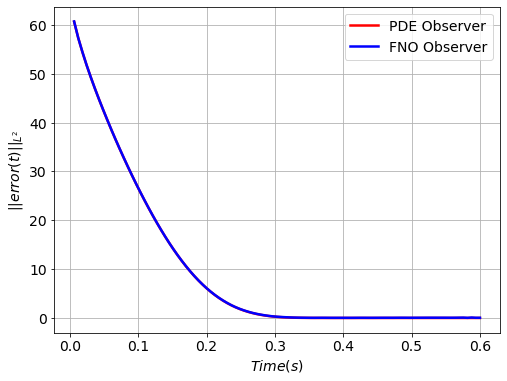

In [ ]:
fig = plt.figure(figsize=(8, 6))
T = 0.6;
tau = 0.6/100;
a = round(T/tau);
t = np.linspace(0, 0.6, 100)
plt.plot(t[1:a], error1norm[1:a], color='red', linewidth=2.5, label = 'PDE Observer')
plt.plot(t[1:a], error2norm[1:a], color='blue', linewidth=2.5, label = 'FNO Observer')
plt.xlabel('$Time (s)$', fontsize =14)
plt.ylabel('$||error(t)||_{L^2}$', fontsize =14);
# plt.yscale('log')
plt.legend(fontsize =14)
plt.grid()
plt.savefig(
    'PT_error{}.eps'.format(index),
    format='eps',
    bbox_inches='tight')
files.download('PT_error{}.eps'.format(index)) 

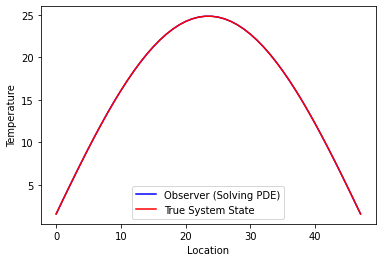

In [ ]:
#plt.plot(pred[index, :, -1, 0], 'b--', label = 'FNO Observer (Data-driven)')
plt.plot(y_test[index, :, -1, 0], 'b', label = 'Observer (Solving PDE)')
plt.plot(truey_test[index, :, -1, 0], 'r', label = 'True System State')
plt.xlabel('Location')
plt.ylabel('Temperature')

plt.legend()

In [ ]:
from google.colab import files
files.download('test1.eps') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
pred2 = torch.zeros(y_test2.shape)

index = 0
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test2, y_test2), batch_size=1, shuffle=False)

a = datetime.datetime.now()
with torch.no_grad():
    for x, y in test_loader:
        test_l2 = 0
        x, y = x.cuda(), y.cuda()

        out = model(x) #.view(-1)
        pred2[index] = out

        test_l2 += myloss(out.view(1, -1), y.view(1, -1)).item()
        print(index, test_l2)
        index = index + 1
b = datetime.datetime.now()
print(b-a)

0 0.005213798023760319
1 0.0025552392471581697
2 0.03231097385287285
3 0.0016671749763190746
4 0.0053359130397439
5 0.004748201929032803
6 0.0033766203559935093
7 0.0012907851487398148
8 0.003025003243237734
9 0.0030940945725888014
10 0.004824278876185417
11 0.0033328819554299116
12 0.0030035560484975576
13 0.0014506271108984947
14 0.004676423501223326
15 0.01851072907447815
16 0.0013525413814932108
17 0.0019134699832648039
18 0.005692831706255674
19 0.0017683458281680942
20 0.00454898364841938
21 0.008999278768897057
22 0.0015117009170353413
23 0.004749116022139788
24 0.0031716029625386
25 0.014855011366307735
26 0.001598981092683971
27 0.0027825806755572557
28 0.0031200998928397894
29 0.0012431007344275713
30 0.013635213486850262
31 0.010492845438420773
32 0.0062432484701275826
33 0.001794950570911169
34 0.002942035673186183
35 0.0025463250931352377
36 0.0016145427944138646
37 0.00510935764759779
38 0.007886658422648907
39 0.0032472177408635616
40 0.0015685695689171553
41 0.002073568

In [ ]:
0.532438/100

0.00532438

### Make Plots

In [ ]:
SMALL_SIZE = 16
MEDIUM_SIZE = 16
BIGGER_SIZE = 16

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


ax.azim = -60
ax.dist = 10
ax.elev = 30


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

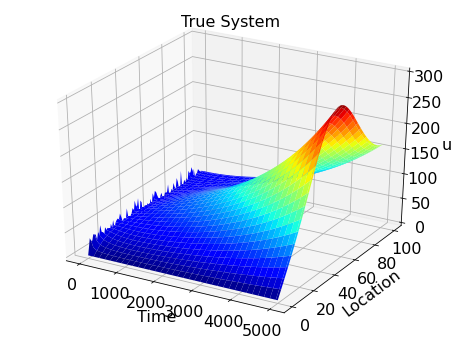

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.gca(projection='3d')

azim = -60
dist = 10
elev = 30

# Make data.
X = np.arange(0, 5001, 50)
Y = np.arange(0, 101, 1)
X, Y = np.meshgrid(X, Y)
vmax = np.max(truey_test2[index, :, :, 0].detach().numpy())

# Plot the surface.
surf = ax.plot_surface(X, Y, truey_test2[index, :, :, 0].detach().numpy(), cmap='jet', vmin=0, vmax=vmax)

# Labels.
ax.set_xlabel('Time')
ax.set_ylabel('Location')
ax.set_zlabel('u')
ax.set_title('True System')
ax.set_zlim([0, 300])

if azim is not None:
    ax.azim = azim
if dist is not None:
    ax.dist = dist
if elev is not None:
    ax.elev = elev

print('ax.azim = {}'.format(ax.azim))
print('ax.dist = {}'.format(ax.dist))
print('ax.elev = {}'.format(ax.elev))

plt.savefig(
    'truey_text{}.eps'.format(index),
    format='eps',
    bbox_inches='tight')
files.download('truey_text{}.eps'.format(index)) 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


ax.azim = -60
ax.dist = 10
ax.elev = 30


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

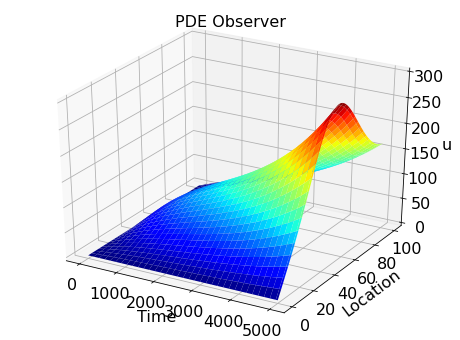

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.gca(projection='3d')

azim = -60
dist = 10
elev = 30

index = 81

# Make data.
X = np.arange(0, 5001, 50)
Y = np.arange(0, 101, 1)
X, Y = np.meshgrid(X, Y)
vmax = np.max(truey_test2[index, :, :, 0].detach().numpy())

# Plot the surface.
surf = ax.plot_surface(X, Y, y_test2[index, :, :, 0].detach().numpy(), cmap='jet', vmin=0, vmax=vmax)

# Labels.
ax.set_xlabel('Time')
ax.set_ylabel('Location')
ax.set_zlabel('u')
ax.set_title('PDE Observer')
ax.set_zlim([0, 300])

if azim is not None:
    ax.azim = azim
if dist is not None:
    ax.dist = dist
if elev is not None:
    ax.elev = elev

print('ax.azim = {}'.format(ax.azim))
print('ax.dist = {}'.format(ax.dist))
print('ax.elev = {}'.format(ax.elev))

plt.savefig(
    'obs_text{}.eps'.format(index),
    format='eps',
    bbox_inches='tight')
files.download('obs_text{}.eps'.format(index)) 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


ax.azim = -60
ax.dist = 10
ax.elev = 30


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

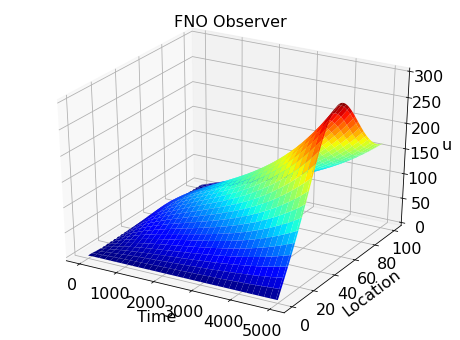

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.gca(projection='3d')

azim = -60
dist = 10
elev = 30

# Make data.
X = np.arange(0, 5001, 50)
Y = np.arange(0, 101, 1)
X, Y = np.meshgrid(X, Y)
vmax = np.max(truey_test2[index, :, :, 0].detach().numpy())

# Plot the surface.
surf = ax.plot_surface(X, Y, pred2[index, :, :, 0].detach().numpy(), cmap='jet', vmin=0, vmax=vmax)

# Labels.
ax.set_xlabel('Time')
ax.set_ylabel('Location')
ax.set_zlabel('u')
ax.set_title('FNO Observer')
ax.set_zlim([0, 300])

if azim is not None:
    ax.azim = azim
if dist is not None:
    ax.dist = dist
if elev is not None:
    ax.elev = elev

print('ax.azim = {}'.format(ax.azim))
print('ax.dist = {}'.format(ax.dist))
print('ax.elev = {}'.format(ax.elev))

plt.savefig(
    'fno_obs_text{}.eps'.format(index),
    format='eps',
    bbox_inches='tight')
files.download('fno_obs_text{}.eps'.format(index)) 

296.3208


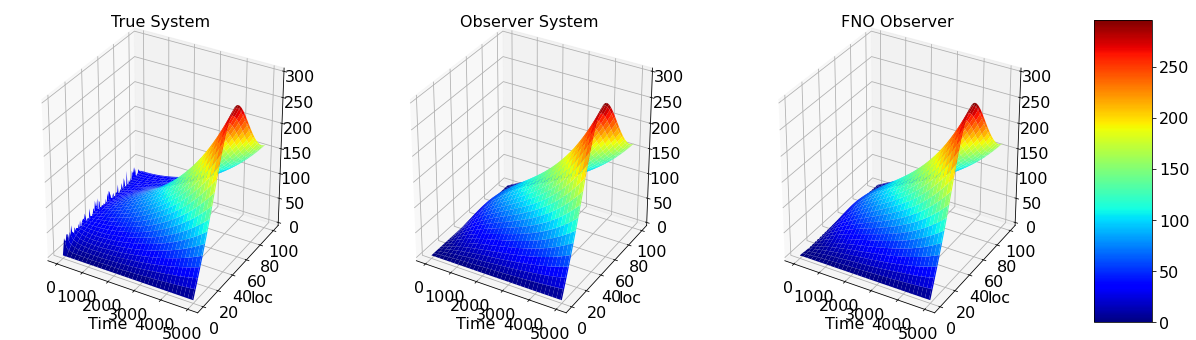

In [ ]:
index = 81

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 6), subplot_kw={"projection": "3d"})
# Make data.
X = np.arange(0, 5001, 50)
Y = np.arange(0, 101, 1)
X, Y = np.meshgrid(X, Y)
vmax = np.max(truey_test2[index, :, :, 0].detach().numpy())
print(vmax)

# Plot the surface.
surf1 = ax[0].plot_surface(X, Y, truey_test2[index, :, :, 0].detach().numpy(), cmap='jet', vmin=0, vmax=vmax)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('loc')
ax[0].set_title('True System')
ax[0].set_zlim([0, 300])
surf2 = ax[1].plot_surface(X, Y, y_test2[index, :, :, 0].detach().numpy(), cmap='jet', vmin=0, vmax=vmax)
ax[1].set_xlabel('Time')
ax[1].set_ylabel('loc')
ax[1].set_zlim([0, 300])
ax[1].set_title('Observer System')
surf3 = ax[2].plot_surface(X, Y, pred2[index, :, :, 0].detach().numpy(), cmap='jet', vmin=0, vmax=vmax)
ax[2].set_xlabel('Time')
ax[2].set_ylabel('loc')
ax[2].set_zlim([0, 300])
ax[2].set_title('FNO Observer')

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(surf1, shrink=0.5, cax=cbar_ax, aspect=5)
#fig.colorbar(surf1, shrink=0.5, aspect=5)

plt.show()

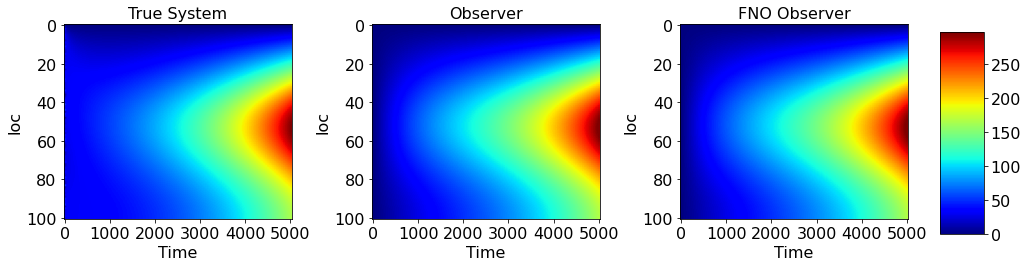

In [ ]:
index = 81
vmax = truey_test2[index, :, :, 0].max()
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
plt.subplot(1, 3, 1)
im1 = plt.imshow(truey_test2[index, :, :, 0], vmin=0, vmax=vmax, cmap='jet', aspect='auto')
plt.xlabel('Time')
plt.xticks([0, 20, 40, 60, 80, 100], [0, 1000, 2000, 3000, 4000, 5000])
plt.ylabel('loc')
plt.title('True System')
plt.subplot(1, 3, 2)
im2 = plt.imshow(y_test2[index, :, :, 0], vmin=0, vmax=vmax, cmap='jet', aspect='auto')
plt.xlabel('Time')
plt.xticks([0, 20, 40, 60, 80, 100], [0, 1000, 2000, 3000, 4000, 5000])
plt.ylabel('loc')
plt.title('Observer')
plt.tight_layout()
plt.subplot(1, 3, 3)
im3 = plt.imshow(pred2[index, :, :, 0], vmin=0, vmax=vmax, cmap='jet', aspect='auto')
plt.xlabel('Time')
plt.xticks([0, 20, 40, 60, 80, 100], [0, 1000, 2000, 3000, 4000, 5000])
plt.ylabel('loc')
plt.title('FNO Observer')
# plt.colorbar()
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(im3, cax=cbar_ax)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


ax.azim = -60
ax.dist = 10
ax.elev = 30


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

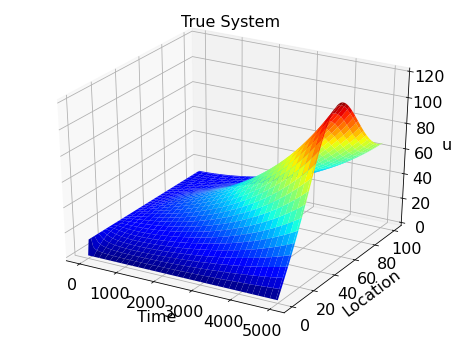

In [ ]:
index = 84

fig = plt.figure(figsize=(8, 6))
ax = fig.gca(projection='3d')

azim = -60
dist = 10
elev = 30

# Make data.
X = np.arange(0, 5001, 50)
Y = np.arange(0, 101, 1)
X, Y = np.meshgrid(X, Y)
vmax = np.max(truey_test[index, :, :, 0].detach().numpy())

# Plot the surface.
surf = ax.plot_surface(X, Y, truey_test[index, :, :, 0].detach().numpy(), cmap='jet', vmin=0, vmax=vmax)

# Labels.
ax.set_xlabel('Time')
ax.set_ylabel('Location')
ax.set_zlabel('u')
ax.set_title('True System')
ax.set_zlim([0, 120])

if azim is not None:
    ax.azim = azim
if dist is not None:
    ax.dist = dist
if elev is not None:
    ax.elev = elev

print('ax.azim = {}'.format(ax.azim))
print('ax.dist = {}'.format(ax.dist))
print('ax.elev = {}'.format(ax.elev))

plt.savefig(
    'truey_text{}.eps'.format(index),
    format='eps',
    bbox_inches='tight')
files.download('truey_text{}.eps'.format(index)) 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


ax.azim = -60
ax.dist = 10
ax.elev = 30


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

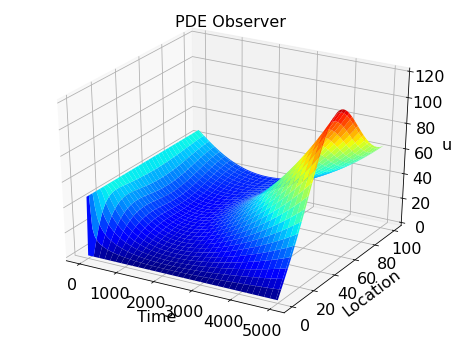

In [ ]:
index = 84

fig = plt.figure(figsize=(8, 6))
ax = fig.gca(projection='3d')

azim = -60
dist = 10
elev = 30

# Make data.
X = np.arange(0, 5001, 50)
Y = np.arange(0, 101, 1)
X, Y = np.meshgrid(X, Y)
vmax = np.max(truey_test[index, :, :, 0].detach().numpy())

# Plot the surface.
surf = ax.plot_surface(X, Y, y_test[index, :, :, 0].detach().numpy(), cmap='jet', vmin=0, vmax=vmax)

# Labels.
ax.set_xlabel('Time')
ax.set_ylabel('Location')
ax.set_zlabel('u')
ax.set_title('PDE Observer')
ax.set_zlim([0, 120])

if azim is not None:
    ax.azim = azim
if dist is not None:
    ax.dist = dist
if elev is not None:
    ax.elev = elev

print('ax.azim = {}'.format(ax.azim))
print('ax.dist = {}'.format(ax.dist))
print('ax.elev = {}'.format(ax.elev))

plt.savefig(
    'obs_text{}.eps'.format(index),
    format='eps',
    bbox_inches='tight')
files.download('obs_text{}.eps'.format(index)) 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


ax.azim = -60
ax.dist = 10
ax.elev = 30


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

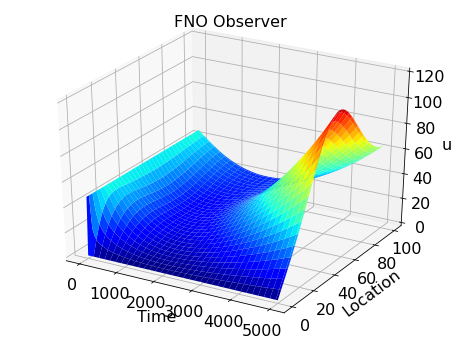

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.gca(projection='3d')

azim = -60
dist = 10
elev = 30

# Make data.
X = np.arange(0, 5001, 50)
Y = np.arange(0, 101, 1)
X, Y = np.meshgrid(X, Y)

# Plot the surface.
surf = ax.plot_surface(X, Y, pred[index, :, :, 0].detach().numpy(), cmap='jet', vmin=0, vmax=vmax)

# Labels.
ax.set_xlabel('Time')
ax.set_ylabel('Location')
ax.set_zlabel('u')
ax.set_title('FNO Observer')
ax.set_zlim([0, 120])

if azim is not None:
    ax.azim = azim
if dist is not None:
    ax.dist = dist
if elev is not None:
    ax.elev = elev

print('ax.azim = {}'.format(ax.azim))
print('ax.dist = {}'.format(ax.dist))
print('ax.elev = {}'.format(ax.elev))

plt.savefig(
    'fno_obs_text{}.eps'.format(index),
    format='eps',
    bbox_inches='tight')
files.download('fno_obs_text{}.eps'.format(index)) 

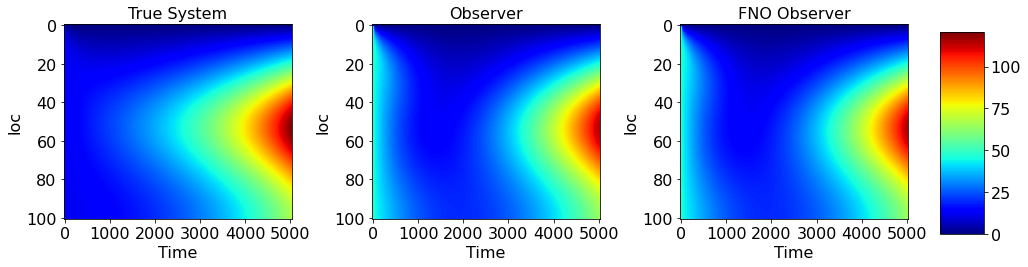

In [ ]:
index = 84
vmax = truey_test[index, :, :, 0].max()
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
plt.subplot(1, 3, 1)
im1 = plt.imshow(truey_test[index, :, :, 0], vmin=0, vmax=vmax, cmap='jet', aspect='auto')
plt.xlabel('Time')
plt.xticks([0, 20, 40, 60, 80, 100], [0, 1000, 2000, 3000, 4000, 5000])
plt.ylabel('loc')
plt.title('True System')
plt.subplot(1, 3, 2)
im2 = plt.imshow(y_test[index, :, :, 0], vmin=0, vmax=vmax, cmap='jet', aspect='auto')
plt.xlabel('Time')
plt.xticks([0, 20, 40, 60, 80, 100], [0, 1000, 2000, 3000, 4000, 5000])
plt.ylabel('loc')
plt.title('Observer')
plt.tight_layout()
plt.subplot(1, 3, 3)
im3 = plt.imshow(pred[index, :, :, 0], vmin=0, vmax=vmax, cmap='jet', aspect='auto')
plt.xlabel('Time')
plt.xticks([0, 20, 40, 60, 80, 100], [0, 1000, 2000, 3000, 4000, 5000])
plt.ylabel('loc')
plt.title('FNO Observer')
# plt.colorbar()
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
fig.colorbar(im3, cax=cbar_ax)

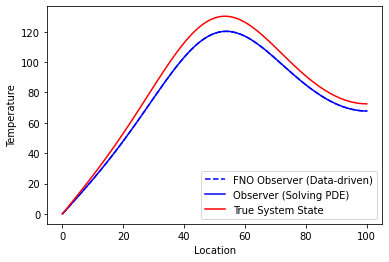

In [ ]:
plt.plot(pred[index, :, -1, 0], 'b--', label = 'FNO Observer (Data-driven)')
plt.plot(y_test[index, :, -1, 0], 'b', label = 'Observer (Solving PDE)')
plt.plot(truey_test[index, :, -1, 0], 'r', label = 'True System State')
plt.xlabel('Location')
plt.ylabel('Temperature')

plt.legend()